In [1]:
import os
os.sys.path
import cv2                 
import numpy as np         
from random import shuffle 
from tqdm import tqdm      

In [2]:
TRAIN_DIR = '/home/sitaramsaini2502/cnn/train1'
IMG_SIZE = 100
LR = 1e-3
MODEL_NAME = 'cnnback200l2-{}-{}.model'.format(LR, 'conv-net') 
def label_img(folder):
    if folder == 'ALB': return [1,0,0,0,0,0]
    elif folder == 'BET': return [0,1,0,0,0,0]
    elif folder == 'DOL': return [0,0,1,0,0,0]
    elif folder == 'LAG': return [0,0,0,1,0,0]
    elif folder == 'SHARK': return [0,0,0,0,1,0]
    elif folder == 'YFT': return [0,0,0,0,0,1]

In [16]:
from skimage import filters
from scipy import ndimage as ndi
from skimage import morphology

In [43]:
training_data3=[]
for folder in tqdm(os.listdir(TRAIN_DIR)):
    for img in tqdm(os.listdir(TRAIN_DIR+"/"+folder)):
        label=label_img(folder)
        path = os.path.join(TRAIN_DIR+"/"+folder,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        #background
        sobel = filters.sobel(img)
        blur = filters.gaussian(sobel, sigma=1.0)
        light_spots = np.array((img > 240).nonzero()).T
        dark_spots = np.array((img < 60).nonzero()).T
        bool_mask = np.zeros(img.shape, dtype=np.bool)
        bool_mask[tuple(light_spots.T)] = True
        bool_mask[tuple(dark_spots.T)] = True
        seed_mask, num_seeds = ndi.label(bool_mask)
        ws = morphology.watershed(blur, seed_mask)
        background = max(set(ws.ravel()), key=lambda g: np.sum(ws == g))
        background_mask = (ws == background)
        cleanedimg = img * ~background_mask
        
        training_data3.append([np.array(cleanedimg),np.array(label)])
        
shuffle(training_data3)
np.save('train_data200back1.npy', training_data3)

 74%|███████▍  | 131/176 [00:03<00:01, 37.14it/s]


100%|██████████| 6/6 [01:02<00:00, 10.47s/it]t/s]


In [3]:
import tensorflow as tf
tf.reset_default_graph()

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 3, activation='elu',regularizer='L2')
convnet = conv_2d(convnet, 32, 1, activation='elu',regularizer='L2')
convnet = max_pool_2d(convnet, 3, strides =2)

convnet = conv_2d(convnet, 64, 3, activation='elu',regularizer='L2')
convnet = conv_2d(convnet, 64, 1, activation='elu',regularizer='L2')
convnet = max_pool_2d(convnet, 3, strides =2)

convnet = conv_2d(convnet, 128, 3, activation='elu',regularizer='L2')
convnet = conv_2d(convnet, 128, 1, activation='elu',regularizer='L2')
convnet = max_pool_2d(convnet, 3, strides =2)

convnet = conv_2d(convnet, 256, 3, activation='elu',regularizer='L2')
convnet = conv_2d(convnet, 256, 1, activation='elu',regularizer='L2')
convnet = max_pool_2d(convnet, 3, strides =2)

convnet = conv_2d(convnet, 384, 3, activation='elu',regularizer='L2')
convnet = conv_2d(convnet, 384, 1, activation='elu',regularizer='L2')
convnet = max_pool_2d(convnet, 3, strides =2)

convnet = conv_2d(convnet, 512, 3, activation='elu',regularizer='L2')
convnet = conv_2d(convnet, 512, 1, activation='elu',regularizer='L2')
convnet = max_pool_2d(convnet, 3, strides =2)
convnet = dropout(convnet, 0.4)

convnet = fully_connected(convnet, 1024, activation='elu',regularizer='L2')
convnet = fully_connected(convnet,6 , activation='softmax',regularizer='L2')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

/home/sitaramsaini2502/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [59]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')
train1 = np.load("/home/sitaramsaini2502/cnn/train_data200back1.npy")
train = train1[:]
test = train1[-1500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit(X, Y, n_epoch=5, validation_set=(test_x, test_y), show_metric=True, snapshot_step=500, run_id=MODEL_NAME)

Training Step: 189  | total loss: 1.11285 | time: 178.432s
| Adam | epoch: 005 | loss: 1.11285 - acc: 0.5600 -- iter: 2368/2393
Training Step: 190  | total loss: 1.09074 | time: 222.058s
| Adam | epoch: 005 | loss: 1.09074 - acc: 0.5665 | val_loss: 1.15932 - val_acc: 0.5287 -- iter: 2393/2393
--


In [60]:
preds = model.predict(test_x)
y_test_non_category = [ np.argmax(t) for t in test_y ]
y_predict_non_category = [ np.argmax(t) for t in preds ]

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)

In [61]:
conf_mat

array([[666,   0,   0,   0,   0,  15],
       [ 88,  10,   0,   0,   0,  27],
       [  7,   0,   0,   0,   0,  66],
       [ 39,   0,   0,   1,   0,   4],
       [ 91,   0,   0,   0,   0,  19],
       [351,   0,   0,   0,   0, 116]])

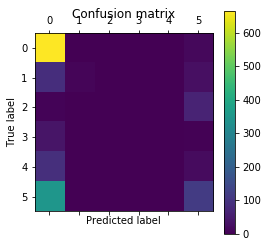

In [63]:
import matplotlib.pyplot as plt
# Plot non-normalized confusion matrix
plt.figure()
plt.matshow(conf_mat)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [4]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')
train1 = np.load("/home/sitaramsaini2502/cnn/train_data200back1.npy")
train = train1[:]
test = train1[-1000:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit(X, Y, n_epoch=100, validation_set=(test_x, test_y), show_metric=True, snapshot_step=500, run_id=MODEL_NAME)

Training Step: 3799  | total loss: 0.26046 | time: 76.626s
| Adam | epoch: 100 | loss: 0.26046 - acc: 0.9652 -- iter: 2368/2393
Training Step: 3800  | total loss: 0.23533 | time: 90.417s
| Adam | epoch: 100 | loss: 0.23533 - acc: 0.9687 | val_loss: 0.03949 - val_acc: 0.9870 -- iter: 2393/2393
--


In [40]:
model.save('/home/sitaramsaini2502/cnn/cnnback200l2-0.001-conv-net.tflearn')

INFO:tensorflow:/home/sitaramsaini2502/cnn/cnnback200l2-0.001-conv-net.tflearn is not in all_model_checkpoint_paths. Manually adding it.


In [9]:
preds = model.predict(test_x)
y_true = [ np.argmax(t) for t in test_y ]
y_pred = [ np.argmax(t) for t in preds ]
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score,roc_curve
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true, y_pred)

In [11]:
conf_mat

array([[433,   5,   0,   0,   0,   2],
       [  0,  90,   0,   0,   0,   0],
       [  0,   0,  53,   0,   0,   0],
       [  0,   0,   0,  32,   0,   0],
       [  0,   0,   0,   0,  70,   0],
       [  2,   4,   0,   0,   0, 309]])

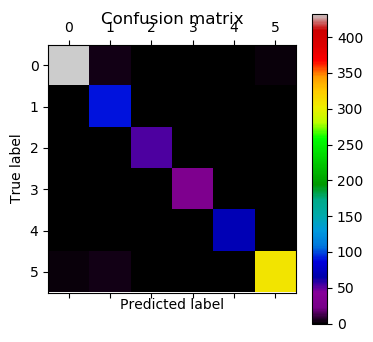

In [34]:
import matplotlib.pyplot as plt
plt.figure()
plt.rcParams['image.cmap'] = 'nipy_spectral'
plt.rcParams['figure.dpi'] = 100
plt.matshow(conf_mat)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

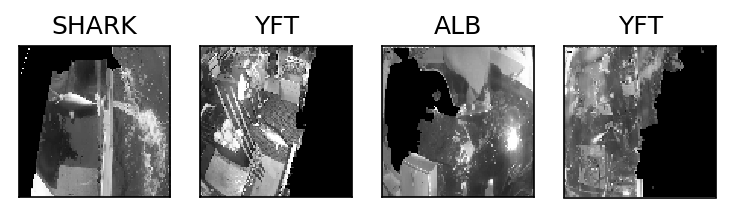

In [38]:
import matplotlib.pyplot as plt
fig=plt.figure()
for num,data in enumerate(test[500:504]):
    img_num = data[1]
    img_data = data[0]    
    y = fig.add_subplot(1,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0] 
    if max(model_out) == model_out[0]: str_label='ALB'
    elif max(model_out) == model_out[1]: str_label='BET'
    elif max(model_out) == model_out[2]: str_label='DOL'
    elif max(model_out) == model_out[3]: str_label='LAG'
    elif max(model_out) == model_out[4]: str_label='SHARK'
    elif max(model_out) == model_out[5]: str_label='YFT'
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'
    plt.rcParams['figure.dpi'] = 150
    y.imshow(orig)
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [41]:
p = model.load('/home/sitaramsaini2502/cnn/cnnback200l2-0.001-conv-net.tflearn')

INFO:tensorflow:Restoring parameters from /home/sitaramsaini2502/cnn/cnnback200l2-0.001-conv-net.tflearn
